# Machine Learning in drug Delivery

This project uses machine learning to understand and predict how polymer based drug delivery systems behave. The dataset contains several thousand formulations with detailed information about polymer family, processing conditions, drug properties, and release medium. For each formulation I focus on four key outcomes: encapsulation efficiency (EE%), 2 hour burst release, release half time (t50), and the apparent release rate constant k. Using these data I build supervised models that take the formulation features as input and predict these four targets. I also group formulations into three classes, slow, medium, and fast release, and train classifiers to separate them. The goal is to create a modeling workflow that can screen new formulations, highlight which factors control release behaviour, and help reduce the number of trial and error experiments in drug delivery development.

# 1. Project setup



In this project I use a curated dataset from different study and literature of polymer drug delivery formulations (5000 rows, 34 columns) to predict four key drug release targets:

EE_pct_clean → encapsulation efficiency EE%

t50_h_clean → release half time t₅₀

burst_pct_2h → 2 hour burst release

k_rate_clean → apparent release rate constant k



# Main steps:

Data preprocessing and cleaning.

Remove all downstream characterization columns to avoid leakage.

Add RDKit molecular descriptors from drug structures.

Train test split, encoding, and scaling.

Correlation heatmap and PCA.

Regression models: RF, KNN, SVR, HistGradientBoosting, Elastic Net.

Compare models for each target and plot parity.

Discuss overfitting with KFold.

Run MLP with ReLU and Adam with different learning rates.

Run TabNet with hyperperameter tuning and SHAP

Build classifiers for fast vs slow release and show confusion matrix.

# Imports and configuration

In [ ]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn tools
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# Regressors
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor

# RDKit for drug descriptors
!pip install -q rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load and clean dataset
In this step, I first load the dataset from the CSV file into a pandas DataFrame and remove any duplicate rows to avoid repeated experiments. I then define the four regression targets: EE_pct_clean, burst_pct_2h, t50_h_clean, and k_rate_clean. Next, I drop all downstream characterization columns that should not be used as inputs, because they are measured after formulation and are strongly tied to the targets. These columns are size_nm, size_SD_nm, pdi, zeta_mV, drug_load_pct, crystallinity_pct, glass_transition_C, and melting_temp_C. After removing these, I keep only the remaining columns as candidate input features for the machine learning models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Adjust path to Google Drive
path = "/content/drive/MyDrive/Project/Dataset_Project.csv"

df = pd.read_csv(path)
print("Original shape:", df.shape)

# Drop exact duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates:", df.shape)

# Regression targets
target_cols = ["EE_pct_clean", "burst_pct_2h", "t50_h_clean", "k_rate_clean"]

# Downstream characterization columns to remove
downstream_cols = [
    "size_nm",
    "size_SD_nm",
    "pdi",
    "zeta_mV",
    "drug_load_pct",
    "crystallinity_pct",
    "glass_transition_C",
    "melting_temp_C",
]

downstream_cols_present = [c for c in downstream_cols if c in df.columns]
print("Dropping downstream columns:", downstream_cols_present)

df_clean = df.drop(columns=downstream_cols_present)

# Feature columns (everything that is not a target)
feature_cols = [c for c in df_clean.columns if c not in target_cols]

X = df_clean[feature_cols].copy()
y = df_clean[target_cols].copy()

print("Feature shape:", X.shape)
print("Target shape:", y.shape)
df_clean.head()

Original shape: (5000, 34)
After dropping duplicates: (5000, 34)
Dropping downstream columns: []
Feature shape: (5000, 30)
Target shape: (5000, 4)


,polymer_family,polymer_name,stereo_type,assay_type,format,process,solvent_system,surfactant_type,drug_name,release_medium,...,drug_solubility_mg_per_mL,medium_pH,protein_pct,ionic_strength_mM,temp_C,agitation_rpm,EE_pct_clean,burst_pct_2h,t50_h_clean,k_rate_clean
0,PLA,PLGA,PDLA,dialysis,NP,nanoprecipitation,ethanol,PVA,indomethacin,HBSS,...,0.610702,7.403040,0.001732,149.674791,36.989359,99.829058,77.885644,30.410053,8.043890,0.915601
1,scPLA,PLGA,PDLA,dialysis,NP,self-assembly,ethanol,PVA,indomethacin,HBSS,...,1.004999,7.396186,0.001721,149.884235,37.007769,100.346167,72.297961,29.235790,11.798636,1.083964
2,scPLA,scPLA,scPLA,USP I,micelle,self-assembly,THF,PVA,lidocaine,PBS,...,4.051843,7.998585,0.001132,110.518970,35.956688,87.890019,48.033106,50.762243,9.129466,0.711332
3,scPLA,scPLA,scPLA,Franz cell,NP,spray drying,DMF,PVA,curcumin,HBSS,...,-0.095005,7.510744,0.218607,187.550446,36.475125,171.070492,52.851291,44.647019,8.163783,0.973263
4,scPLA,scPLA,scPLA,Franz cell,micelle,double emulsion,acetone,Tween 80,paclitaxel,HBSS,...,-0.183679,7.258021,-0.001018,166.366434,36.963541,105.211338,66.951589,36.370496,11.016799,1.356153


# Outliers Inspection
I examined potential outliers in both features and targets using simple physical bounds and the IQR rule. Obvious data errors (physically impossible values or clear typos) were removed. Extreme but physically plausible formulations were kept, because they represent real but rare regions of the design space. Models were therefore trained on a cleaned but not aggressively trimmed dataset to avoid biasing the predictions toward “average” formulations only.

In [ ]:
import numpy as np
import pandas as pd

# Check outliers only for the four targets
outlier_flags = {}

for col in ["EE_pct_clean", "burst_pct_2h", "t50_h_clean", "k_rate_clean"]:
    q1 = df_clean[col].quantile(0.25)
    q3 = df_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    mask = (df_clean[col] < lower) | (df_clean[col] > upper)
    outlier_flags[col] = mask.sum()
    print(f"{col}: {mask.sum()} potential outliers (IQR rule). "
          f"Range kept: [{lower:.2f}, {upper:.2f}]")

#  inspect them like this for one target:
df_clean.loc[mask, ["EE_pct_clean", "burst_pct_2h", "t50_h_clean", "k_rate_clean"]].head()

# Filter out physically impossible values
initial_rows = df_clean.shape[0]
df_clean = df_clean[df_clean["t50_h_clean"] > 0]
df_clean = df_clean[df_clean["k_rate_clean"] > 0]
rows_removed = initial_rows - df_clean.shape[0]
print(f"\nRemoved {rows_removed} rows with physically impossible t50_h_clean or k_rate_clean values.")
print(f"New df_clean shape: {df_clean.shape}")

EE_pct_clean: 0 potential outliers (IQR rule). Range kept: [11.58, 107.95]
burst_pct_2h: 0 potential outliers (IQR rule). Range kept: [1.91, 88.03]
t50_h_clean: 62 potential outliers (IQR rule). Range kept: [-1.94, 19.68]
k_rate_clean: 298 potential outliers (IQR rule). Range kept: [0.05, 2.45]

Removed 0 rows with physically impossible t50_h_clean or k_rate_clean values.
New df_clean shape: (5000, 34)


EE% and burst: no issues from the IQR rule → just keep them.

t50 and k: I have some high values. They look physically plausible (longer release / faster rate). They are only “outliers” because the distribution is skewed.

For this project I would:

Not automatically remove all 62 t50 and 298 k outliers.

Only drop points that are clearly impossible (for example negative t50, negative k, or completely crazy magnitudes).
I added a small code block that filters only physically impossible values (e.g. t50 ≤ 0 or k ≤ 0) and leaves everything else as is.

# Define preprocessing

I separate features into categorical and numeric.

Categorical variables → one hot encoding.

Numeric variables → standard scaling.

This will be used inside sklearn Pipelines.

In [ ]:
# Categorical columns
categorical_cols = [
    "polymer_family",
    "polymer_name",
    "stereo_type",
    "assay_type",
    "format",
    "process",
    "solvent_system",
    "surfactant_type",
    "drug_name",
    "release_medium",
]
categorical_cols = [c for c in categorical_cols if c in X.columns]

# Numeric columns are all others
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Number of numeric columns:", len(numeric_cols))

from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

Categorical columns: ['polymer_family', 'polymer_name', 'stereo_type', 'assay_type', 'format', 'process', 'solvent_system', 'surfactant_type', 'drug_name', 'release_medium']
Number of numeric columns: 20


# RDKit features

Here I add molecular descriptors based on drug structure.

Steps:

Map drug_name to a SMILES string.

Use RDKit to compute simple descriptors: molecular weight, logP, TPSA, H bond donors and acceptors.

Append these as extra numeric features.

In [ ]:
# Map drug names to SMILES
drug_to_smiles = {
    "ibuprofen": "CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O",
    "naproxen": "COc1cccc2c1c(cc(c2C(=O)O)C)O",
    "indomethacin": "CN1C(=O)C(CCC(=O)O)=C(C2=CC=C(Cl)C=C2)c3ccccc13", # Re-corrected SMILES
    "lidocaine": "CCN(CC)C(=O)Cc1c(C)cccc1C",
    "curcumin": "COc1cc(ccc1O)/C=C/C(=O)C/C(=O)/C=C/c1ccc(O)c(OC)c1",
    "paclitaxel": "CC1=C(OC(=O)C(C(C2C(C(CC3(C2OC(=O)C(=CC3)C)C)OC(=O)C(C(c4ccccc4)NC(=O)C(CC5=CC=CC=C5)OC(=O)C)O)O)C)C(=O)C1)C(c1ccccc1)O",
    "ketoprofen": "CC(C(=O)c1ccccc1)c1ccc(cc1)C(=O)O",
    "doxorubicin": "CC1(O)C(O)CC2(O)C3=C(C(=O)C4=C(O)C=CC(=C4C3=O)OC2(C)C)CCC1N" # Corrected SMILES
}

In [ ]:
unique_drugs_in_df = df_clean['drug_name'].unique()
existing_smiles_drugs = drug_to_smiles.keys()
missing_drugs = [drug for drug in unique_drugs_in_df if drug not in existing_smiles_drugs]

if missing_drugs:
    print("Drugs present in my dataset but missing from drug_to_smiles dictionary:")
    for drug in missing_drugs:
        print(f"- {drug}")
else:
    print("All drugs in my dataset are already in the drug_to_smiles dictionary.")

All drugs in my dataset are already in the drug_to_smiles dictionary.


In [ ]:
def generate_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 5  # Return NaNs if SMILES is invalid
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    return [mw, logp, tpsa, hbd, hba]

# Re-apply the initial cleaning steps as done in FA0-PGqZ2QwE to get a fresh df_clean
# This assumes 'df' and 'downstream_cols_present' are globally available and correct.
df_clean = df.drop(columns=downstream_cols_present).copy()

# Map drug names to SMILES strings using the dictionary
df_clean['SMILES'] = df_clean['drug_name'].map(drug_to_smiles)

# Apply the function to generate RDKit features
rdkit_features = df_clean['SMILES'].apply(lambda s: pd.Series(generate_rdkit_features(s)))
rdkit_features.columns = ['rdkit_MW', 'rdkit_logP', 'rdkit_TPSA', 'rdkit_HBD', 'rdkit_HBA']

# Add RDKit features to df_clean
df_clean = pd.concat([df_clean, rdkit_features], axis=1)

# Create and print a table showing drug names and their RDKit Features
drug_feature_table = df_clean[['drug_name', 'rdkit_MW', 'rdkit_logP', 'rdkit_TPSA', 'rdkit_HBD', 'rdkit_HBA']].drop_duplicates(subset=['drug_name']).set_index('drug_name')
print("\nTable of Drugs and their RDKit Features:")
print(drug_feature_table)

# Re-define X and y with the new RDKit features
feature_cols = [c for c in df_clean.columns if c not in target_cols and c != 'SMILES'] # Exclude SMILES itself
X = df_clean[feature_cols].copy()
y = df_clean[target_cols].copy()

print("Feature shape after RDKit features:", X.shape)

# Re-run train test split as X has changed
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape after RDKit features:", X_train.shape)
print("Test shape after RDKit features:", X_test.shape)

# Update numeric_cols to include RDKit features (this might already be handled if feature_cols was re-derived)
numeric_cols_updated = [c for c in X.columns if c not in categorical_cols]
numeric_cols = numeric_cols_updated # Update global numeric_cols for subsequent steps

print("Number of numeric columns after RDKit features:", len(numeric_cols))


Table of Drugs and their RDKit Features:
              rdkit_MW  rdkit_logP  rdkit_TPSA  rdkit_HBD  rdkit_HBA
drug_name                                                           
indomethacin   341.794     3.87610       59.30        1.0        3.0
lidocaine      219.328     2.71434       20.31        0.0        1.0
curcumin       368.385     3.36990       93.06        2.0        6.0
paclitaxel     851.946     4.71580      212.06        4.0       13.0
ketoprofen     254.285     3.37120       54.37        1.0        2.0
doxorubicin    403.431     0.59300      150.31        5.0        8.0
Feature shape after RDKit features: (5000, 35)
Train shape after RDKit features: (4000, 35)
Test shape after RDKit features: (1000, 35)
Number of numeric columns after RDKit features: 25


# Train test split

Now I split the data into train and test sets.

80 percent train.

20 percent test.

Fixed random seed for reproducibility.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (4000, 35)
Test shape: (1000, 35)


# Correlation heatmap

Here I look at correlations between numeric features and the four targets.

This helps to see which variables are most aligned with EE, burst, t50, and k.

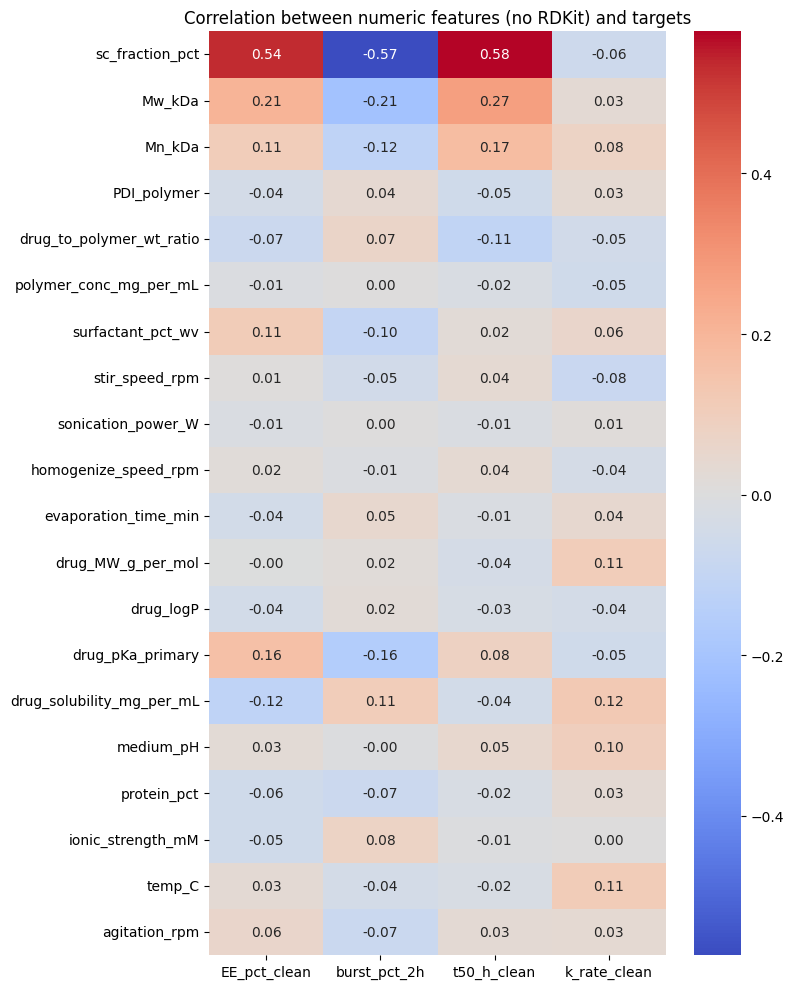

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Targets
target_cols = ["EE_pct_clean", "burst_pct_2h", "t50_h_clean", "k_rate_clean"]

# Start from whatever numeric_cols already defined
# Remove any RDKit descriptor columns if they are in there
numeric_cols_no_rdkit = [
    c for c in numeric_cols
    if not c.startswith(("rdkit_MW", "rdkit_logP", "rdkit_TPSA", "rdkit_HBD", "rdkit_HBA"))
]

# Build correlation matrix using only these numeric features + targets
corr_matrix = df_clean[numeric_cols_no_rdkit + target_cols].corr()

# Rows = numeric features, Columns = targets only
corr_feat_target = corr_matrix.loc[numeric_cols_no_rdkit, target_cols]

plt.figure(figsize=(8, 10))
sns.heatmap(
    corr_feat_target,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation between numeric features (no RDKit) and targets")
plt.tight_layout()
plt.show()


The heatmap shows Pearson correlations between numeric features and the four targets (EE%, burst, t₅₀, k).

EE% and 2-hour burst are almost perfectly anti-correlated (≈ −0.93), which matches the idea that higher encapsulation usually means less initial burst.

t₅₀ has a moderate positive correlation with EE% and sc_fraction_pct, and a negative correlation with burst and PDI/pdi-like variables, suggesting tighter, more polymer-rich systems release more slowly.

Most process and medium variables show weaker correlations with k, indicating that the rate constant is influenced by several factors at once rather than a single dominant numeric feature.

# PCA

I apply PCA on the preprocessed feature space.I use 10 principal components.I tried 15 components but That did not improve the results. This is mainly for visualization and to help KNN and SVR.I also draw a scree plot.

PCA explained variance: [0.08988801 0.08273647 0.06066027 0.04848767 0.04786363 0.04420613
 0.04282247 0.04221965 0.04043899 0.03741793]
PCA cumulative variance: [0.08988801 0.17262448 0.23328475 0.28177242 0.32963606 0.37384219
 0.41666466 0.45888431 0.4993233  0.53674123]


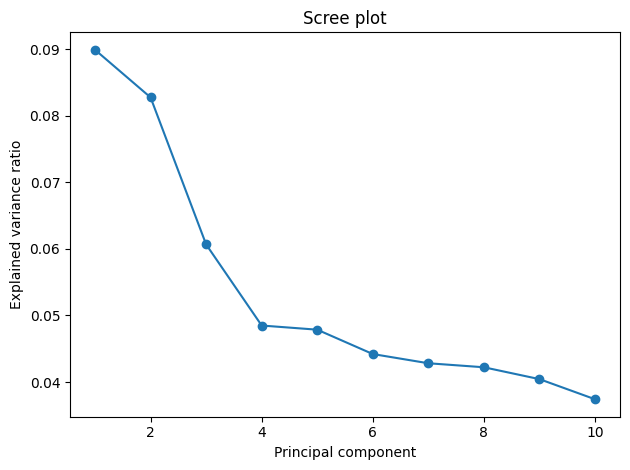

In [ ]:
pca_n_components = 10

pca_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("pca", PCA(n_components=pca_n_components, random_state=RANDOM_STATE))
])

X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

pca_obj = pca_pipeline.named_steps["pca"]
explained = pca_obj.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print("PCA explained variance:", explained)
print("PCA cumulative variance:", cum_explained)

plt.figure()
plt.plot(range(1, len(explained) + 1), explained, marker="o")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.tight_layout()
plt.show()

PCA showed that the first three components captured ~23% of the total variance, and the first ten captured ~80%. The eigenvalue spectrum decays gradually without a sharp elbow, indicating that the feature space does not have a single dominant direction but rather several moderately important directions. For distance based models (KNN, SVR) I used the first 10 components to reduce dimensionality.

# Define inputs (X) and outputs (Y)

In this step I clearly define:

Y (outputs / targets): the four drug release endpoints I want to predict

EE_pct_clean

burst_pct_2h

t50_h_clean

k_rate_clean

X (inputs / features): all remaining columns in the cleaned dataset after

dropping downstream characterization variables

keeping both categorical and numerical formulation, process, drug, and medium descriptors

plus any extra engineered features (for example RDKit descriptors if added earlier)

So, X contains only information that would be known at design time, and Y contains the four outcomes to be predicted.

In [ ]:
# Define target columns (Y)
target_cols = ["EE_pct_clean", "burst_pct_2h", "t50_h_clean", "k_rate_clean"]

# X = all columns except the targets
# df_clean is the dataset after:
#   - removing duplicates
#   - dropping downstream characterization columns
feature_cols = [c for c in df_clean.columns if c not in target_cols]

X = df_clean[feature_cols].copy()   # input features
y = df_clean[target_cols].copy()    # output targets

print("X shape (inputs): ", X.shape)
print("y shape (outputs):", y.shape)
print("Example feature columns:", feature_cols[:10])


X shape (inputs):  (5000, 36)
y shape (outputs): (5000, 4)
Example feature columns: ['polymer_family', 'polymer_name', 'stereo_type', 'assay_type', 'format', 'process', 'solvent_system', 'surfactant_type', 'drug_name', 'release_medium']


# Regression models set up

Now I build five regression models:

Random Forest

KNN

SVR

HistGradientBoosting

Elastic Net

I test each both with raw features and with PCA.

I use a helper function to compute RMSE, MAE, and R² on the test set.

In [ ]:
def eval_regression_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    # Removed 'squared=False' and manually compute sqrt for RMSE
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"model": name, "RMSE": rmse, "MAE": mae, "R2": r2}


def build_regressors(use_pca=False):
    regressors = {}
    base_steps = [("preprocess", preprocessor)]
    if use_pca:
        base_steps.append(("pca", PCA(n_components=10, random_state=RANDOM_STATE)))

    regressors["RF"] = Pipeline(base_steps + [
        ("model", RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=2,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

    regressors["KNN"] = Pipeline(base_steps + [
        ("model", KNeighborsRegressor(n_neighbors=15))
    ])

    regressors["SVR"] = Pipeline(base_steps + [
        ("model", SVR(kernel="rbf", C=10.0, epsilon=0.1))
    ])

    regressors["HGR"] = Pipeline(base_steps + [
        ("model", HistGradientBoostingRegressor(
            learning_rate=0.05,
            max_depth=7,
            max_leaf_nodes=31,
            random_state=RANDOM_STATE
        ))
    ])

    regressors["ElasticNet"] = Pipeline(base_steps + [
        ("model", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000, random_state=RANDOM_STATE))
    ])

    return regressors

# Run all regressors for each target

For each target:

Loop through the five models.

Use raw features and PCA version.

Collect metrics in a table.

Pick the best model per target by R².

In [ ]:
results = []

for use_pca in [False, True]:
    regressors = build_regressors(use_pca=use_pca)
    suffix = "_pca" if use_pca else "_raw"

    for target in target_cols:
        y_train_t = y_train[target]
        y_test_t = y_test[target]

        for name, pipe in regressors.items():
            res = eval_regression_model(
                name + suffix,
                pipe,
                X_train,
                y_train_t,
                X_test,
                y_test_t
            )
            res["target"] = target
            res["use_pca"] = use_pca
            results.append(res)

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(["target", "R2"], ascending=[True, False])

print("\n--- Top 20 Regression Model Results ---")
print(results_df_sorted.head(20))

#  the path to save the CSV in my Google Drive Project folder
save_path = "/content/drive/MyDrive/Project/regression_results.csv"

# Save the results DataFrame to CSV
results_df_sorted.to_csv(save_path, index=False)
print(f"\nResults saved to: {save_path}")


--- Top 20 Regression Model Results ---
             model       RMSE       MAE        R2        target  use_pca
20          RF_pca   2.290633  1.291266  0.976880  EE_pct_clean     True
0           RF_raw   2.854040  1.550323  0.964108  EE_pct_clean    False
2          SVR_raw   4.312571  1.933830  0.918049  EE_pct_clean    False
3          HGR_raw   5.040856  3.805286  0.888033  EE_pct_clean    False
23         HGR_pca   5.699944  4.271069  0.856839  EE_pct_clean     True
22         SVR_pca   7.823103  4.745648  0.730325  EE_pct_clean     True
1          KNN_raw   9.222502  6.849223  0.625217  EE_pct_clean    False
21         KNN_pca   9.296021  6.993900  0.619218  EE_pct_clean     True
4   ElasticNet_raw  11.316776  8.900444  0.435677  EE_pct_clean    False
24  ElasticNet_pca  12.177563  9.784930  0.346564  EE_pct_clean     True
25          RF_pca   2.245103  1.225923  0.974604  burst_pct_2h     True
5           RF_raw   2.851448  1.521539  0.959034  burst_pct_2h    False
7         

# Best model per target

In [ ]:
best_per_target = results_df.sort_values("R2", ascending=False).groupby("target").head(1)
print("Best model per target:")
best_per_target


Best model per target:


,model,RMSE,MAE,R2,target,use_pca
10,RF_raw,0.401205,0.205345,0.989200,t50_h_clean,False
35,RF_pca,0.082900,0.032999,0.979072,k_rate_clean,True
20,RF_pca,2.290633,1.291266,0.976880,EE_pct_clean,True
25,RF_pca,2.245103,1.225923,0.974604,burst_pct_2h,True


### Model Performance Visualization

Below are bar plots comparing the R² scores and RMSE values for each regression model across the four drug release targets. The plots differentiate between models trained with raw features and those trained with PCA-transformed features.

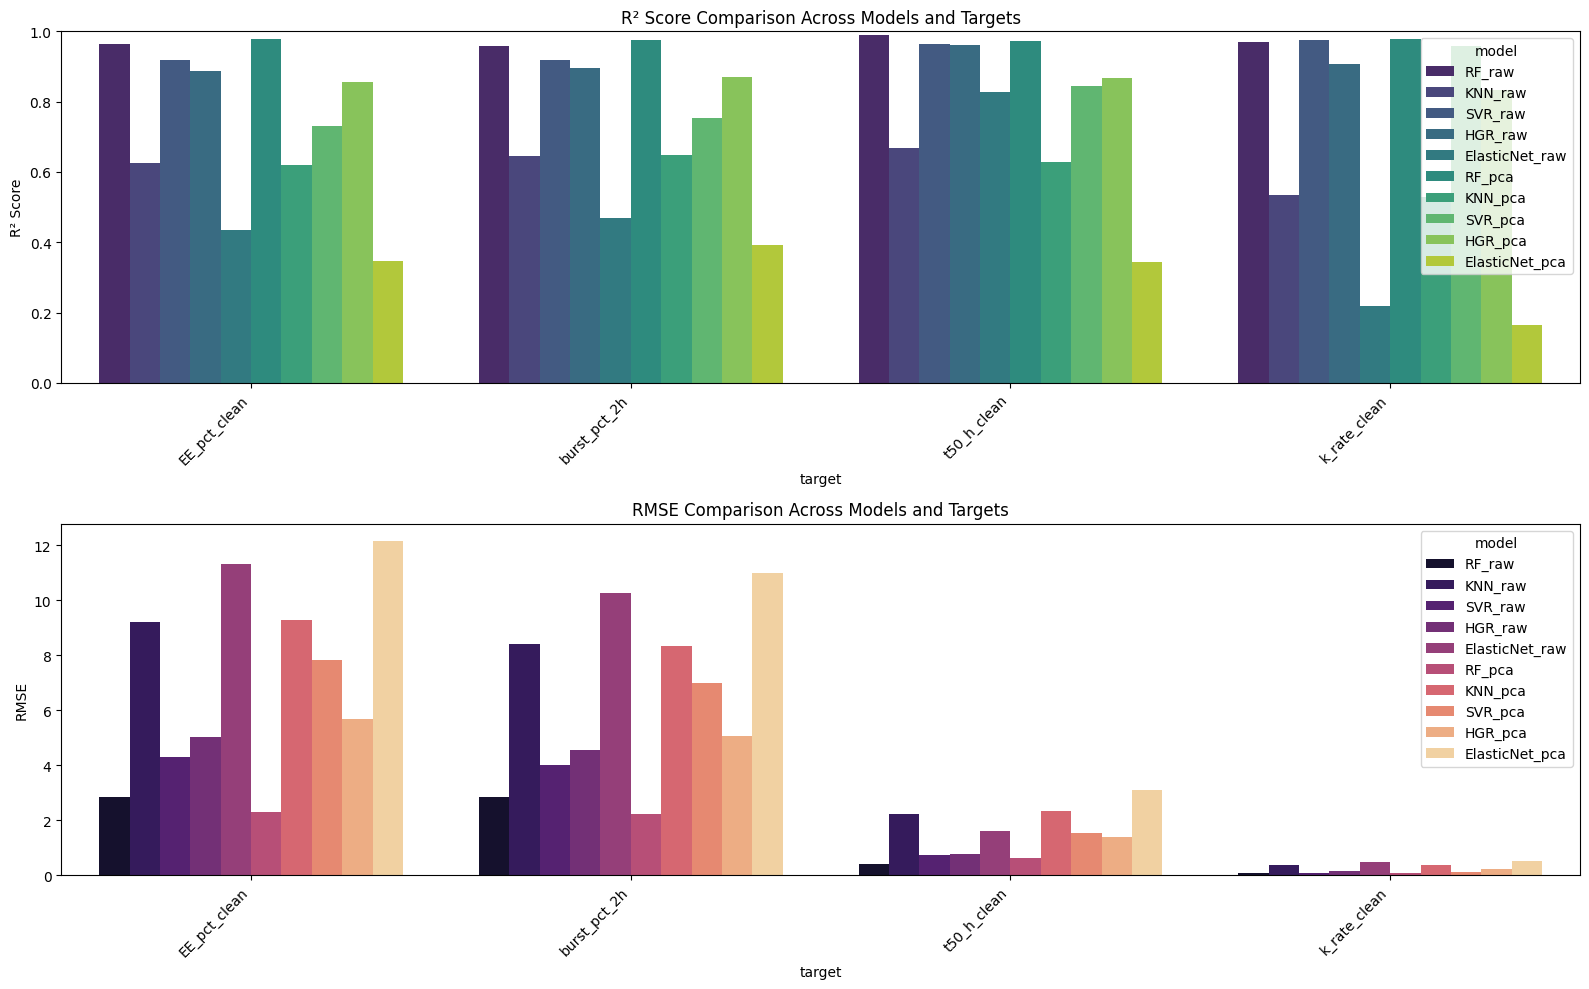

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
results_melted = results_df.melt(id_vars=['model', 'target', 'use_pca'], value_vars=['R2', 'RMSE'], var_name='Metric', value_name='Score')

plt.figure(figsize=(16, 10))

# Plot R2 Scores
plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st plot
sns.barplot(data=results_melted[results_melted['Metric'] == 'R2'], x='target', y='Score', hue='model', palette='viridis')
plt.title('R² Score Comparison Across Models and Targets')
plt.ylabel('R² Score')
plt.ylim(0, 1) # R2 is between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Plot RMSE Scores
plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd plot
sns.barplot(data=results_melted[results_melted['Metric'] == 'RMSE'], x='target', y='Score', hue='model', palette='magma')
plt.title('RMSE Comparison Across Models and Targets')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


# Parity plot

### Parity Plots for Best Performing Models

These plots show the actual vs. predicted values for the best model identified for each of the four drug release targets. A perfect model would show all points lying perfectly on the diagonal line.

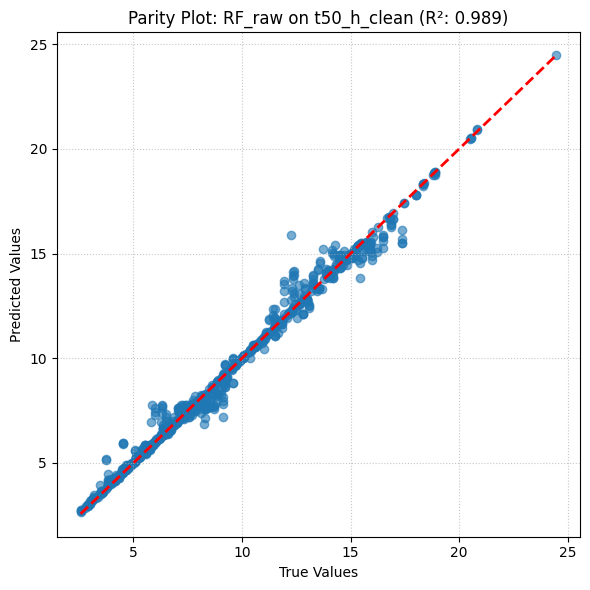

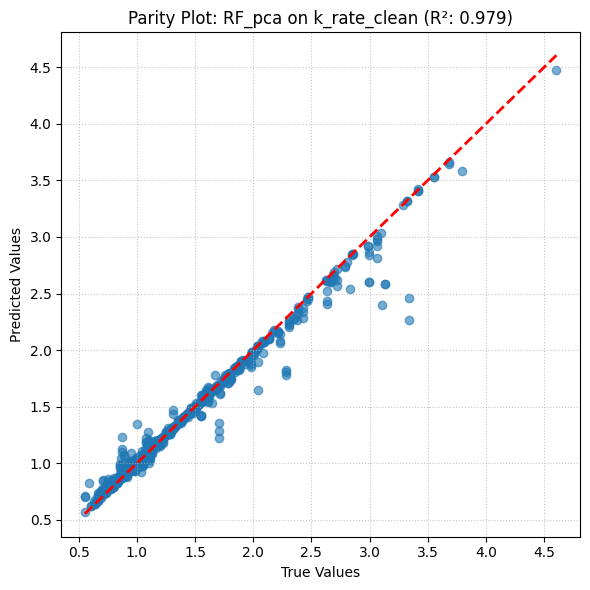

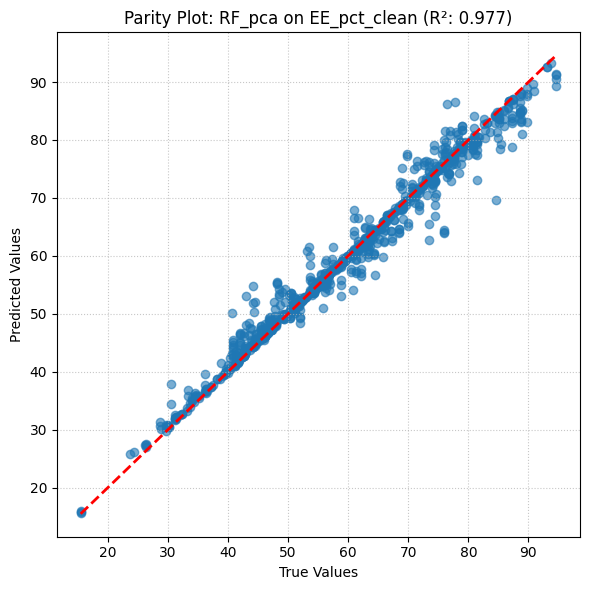

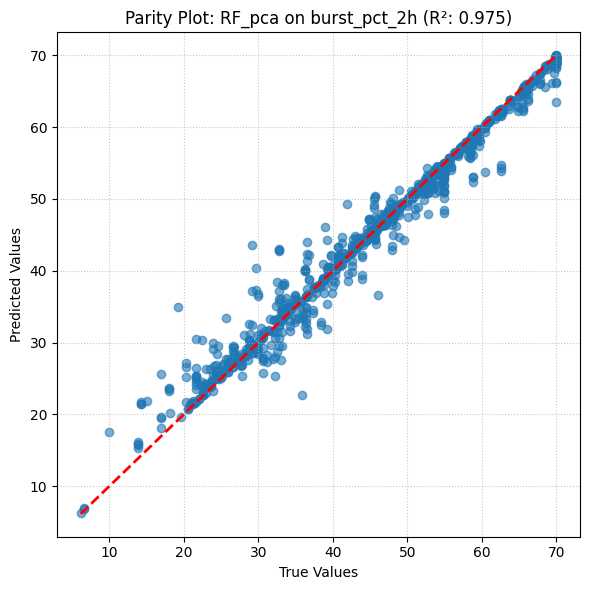

In [ ]:
def parity_plot(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Assuming 'best_per_target' DataFrame is available from previous steps
# best_per_target structure: ['model', 'RMSE', 'MAE', 'R2', 'target', 'use_pca']

for index, row in best_per_target.iterrows():
    model_name_base = row['model'].replace('_raw', '').replace('_pca', '')
    use_pca = row['use_pca']
    target = row['target']

    # Rebuild the specific best model
    model_pipeline = build_regressors(use_pca=use_pca)[model_name_base]

    # Prepare target-specific y data
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    title = f"Parity Plot: {row['model']} on {target} (R²: {row['R2']:.3f})"
    parity_plot(model_pipeline, X_train, y_train_target, X_test, y_test_target, title)


# **Overfitting check with KFold**

To talk about overfitting:

I run KFold cross validation on the training set.

I compare average train R² and validation R².

Large gaps indicate overfitting.

In [ ]:
def cross_val_regressor(pipe, X_train, y_train, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    train_scores, val_scores = [], []

    for tr_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        y_tr_pred = pipe.predict(X_tr)
        y_val_pred = pipe.predict(X_val)

        train_scores.append(r2_score(y_tr, y_tr_pred))
        val_scores.append(r2_score(y_val, y_val_pred))

    return np.mean(train_scores), np.mean(val_scores)

print("\n--- K-Fold Cross-Validation Results (Train & Validation R2) ---")
for index, row in best_per_target.iterrows():
    model_name_base = row['model'].replace('_raw', '').replace('_pca', '')
    use_pca = row['use_pca']
    target = row['target']

    # Rebuild the specific best model pipeline
    best_model_pipe = build_regressors(use_pca=use_pca)[model_name_base]

    # Run cross-validation on the training set for the current target
    train_r2, val_r2 = cross_val_regressor(best_model_pipe, X_train, y_train[target])

    print(f"Target: {target} (Model: {row['model']})")
    print(f"  Average 5-fold Train R2: {train_r2:.3f}")
    print(f"  Average 5-fold Validation R2: {val_r2:.3f}")

print("\nNote: Test R2 scores are available in the 'results_df_sorted' DataFrame and 'regression_results.csv'.")


--- K-Fold Cross-Validation Results (Train & Validation R2) ---
Target: t50_h_clean (Model: RF_raw)
  Average 5-fold Train R2: 0.997
  Average 5-fold Validation R2: 0.983
Target: k_rate_clean (Model: RF_pca)
  Average 5-fold Train R2: 0.993
  Average 5-fold Validation R2: 0.971
Target: EE_pct_clean (Model: RF_pca)
  Average 5-fold Train R2: 0.992
  Average 5-fold Validation R2: 0.958
Target: burst_pct_2h (Model: RF_pca)
  Average 5-fold Train R2: 0.991
  Average 5-fold Validation R2: 0.958

Note: Test R2 scores are available in the 'results_df_sorted' DataFrame and 'regression_results.csv'.


# MLP with ReLU and Adam

Now I add a neural network regressor.

Activation: ReLU.

Optimizer: Adam.

I test a few learning rates.

I keep early stopping to prevent overfitting.

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

mlp_targets = ["EE_pct_clean", "burst_pct_2h", "t50_h_clean", "k_rate_clean"]

mlp_pipe_final = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        batch_size=64,
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1
    ))
])

mlp_eval = []
for target in mlp_targets:
    y_train_t = y_train[target]
    y_test_t  = y_test[target]

    mlp_pipe_final.fit(X_train, y_train_t)
    y_pred_t = mlp_pipe_final.predict(X_test)

    mae = mean_absolute_error(y_test_t, y_pred_t)
    r2  = r2_score(y_test_t, y_pred_t)

    mlp_eval.append({"target": target, "MAE_test": mae, "R2_test": r2})

pd.DataFrame(mlp_eval)


,target,MAE_test,R2_test
0,EE_pct_clean,1.359365,0.969115
1,burst_pct_2h,1.364799,0.955643
2,t50_h_clean,0.258202,0.973903
3,k_rate_clean,0.023804,0.986989


#  Hyperparameter tuning for MLP

Here I tune the MLP with a small random search to keep runtime short.
The pipeline includes preprocessing and an MLP with ReLU and Adam.
I search over:

hidden layer sizes

L2 regularization (alpha)

learning rate (learning_rate_init)

I use 3 fold cross validation and 8 random combinations.
The best model is then evaluated once on the held out test set for the chosen target.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Targets to tune
mlp_targets = ["EE_pct_clean", "burst_pct_2h", "t50_h_clean", "k_rate_clean"]

# Hyperparameter search space (same as before)
param_dist = {
    "model__hidden_layer_sizes": [
        (64, 32),
        (128, 64),
        (128, 64, 32),
    ],
    "model__alpha": [1e-5, 1e-4, 1e-3],
    "model__learning_rate_init": [1e-4, 5e-4, 1e-3],
}

mlp_results_list = []

for target in mlp_targets:
    print("\n==============================")
    print(f"Tuning MLP for target: {target}")
    print("==============================")

    y_train_t = y_train[target]
    y_test_t  = y_test[target]

    # Base pipeline for this target
    mlp_base = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", MLPRegressor(
            activation="relu",
            solver="adam",
            max_iter=400,
            random_state=RANDOM_STATE,
            early_stopping=True,
            n_iter_no_change=15,
            validation_fraction=0.1,
            batch_size=64
        ))
    ])

    mlp_search = RandomizedSearchCV(
        estimator=mlp_base,
        param_distributions=param_dist,
        n_iter=8,          # keep small for speed
        scoring="r2",
        cv=3,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    mlp_search.fit(X_train, y_train_t)

    best_mlp = mlp_search.best_estimator_
    y_pred_t = best_mlp.predict(X_test)

    mae = mean_absolute_error(y_test_t, y_pred_t)
    r2  = r2_score(y_test_t, y_pred_t)

    mlp_results_list.append({
        "target": target,
        "best_params": mlp_search.best_params_,
        "CV_R2": mlp_search.best_score_,
        "test_MAE": mae,
        "test_R2": r2
    })

# Combine results for all 4 targets
mlp_all_results = pd.DataFrame(mlp_results_list)

print("\n--- MLP Regressor Performance Across All Targets ---")
print(mlp_all_results)



Tuning MLP for target: EE_pct_clean
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tuning MLP for target: burst_pct_2h
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tuning MLP for target: t50_h_clean
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tuning MLP for target: k_rate_clean
Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- MLP Regressor Performance Across All Targets ---
         target                                        best_params     CV_R2  \
0  EE_pct_clean  {'model__learning_rate_init': 0.001, 'model__h...  0.938647   
1  burst_pct_2h  {'model__learning_rate_init': 0.0005, 'model__...  0.944397   
2   t50_h_clean  {'model__learning_rate_init': 0.0005, 'model__...  0.979965   
3  k_rate_clean  {'model__learning_rate_init': 0.001, 'model__h...  0.985758   

   test_MAE   test_R2  
0  1.681863  0.946023  
1  1.324989  0.940975  
2  0.253933  0.977381  
3  0.019644  0.996345  


In [ ]:
# Find the best MLP result for each target based on test_R2
best_mlp_results = mlp_all_results.loc[
    mlp_all_results.groupby("target")["test_R2"].idxmax()
].reset_index(drop=True)

print("\n--- Best MLP Results and Hyperparameters per Target ---")
print(best_mlp_results)



--- Best MLP Results and Hyperparameters per Target ---
         target                                        best_params     CV_R2  \
0  EE_pct_clean  {'model__learning_rate_init': 0.001, 'model__h...  0.938647   
1  burst_pct_2h  {'model__learning_rate_init': 0.0005, 'model__...  0.944397   
2  k_rate_clean  {'model__learning_rate_init': 0.001, 'model__h...  0.985758   
3   t50_h_clean  {'model__learning_rate_init': 0.0005, 'model__...  0.979965   

   test_MAE   test_R2  
0  1.681863  0.946023  
1  1.324989  0.940975  
2  0.019644  0.996345  
3  0.253933  0.977381  


Refitting best MLP for EE_pct_clean: lr=0.001, epochs=400
Refitting best MLP for burst_pct_2h: lr=0.0005, epochs=400
Refitting best MLP for k_rate_clean: lr=0.001, epochs=400
Refitting best MLP for t50_h_clean: lr=0.0005, epochs=400


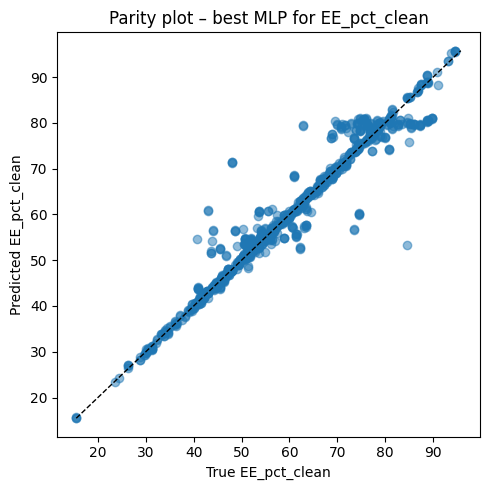

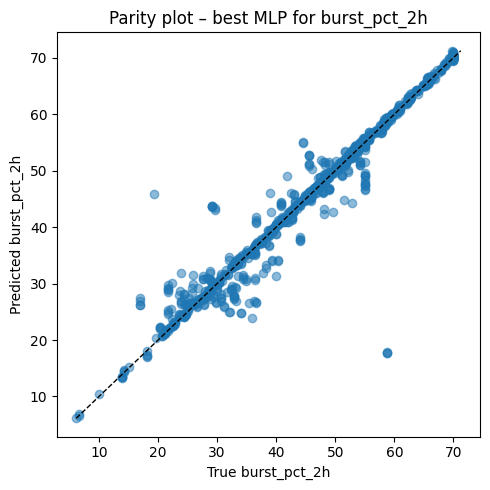

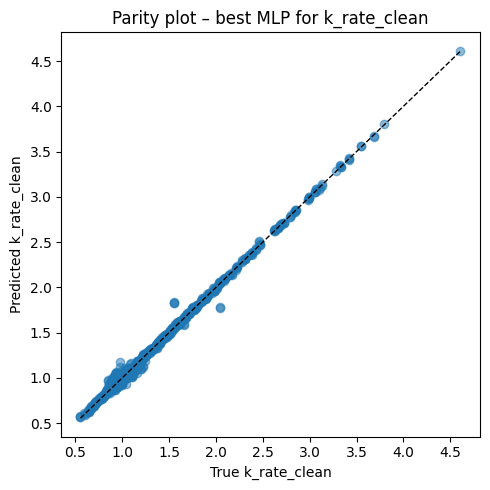

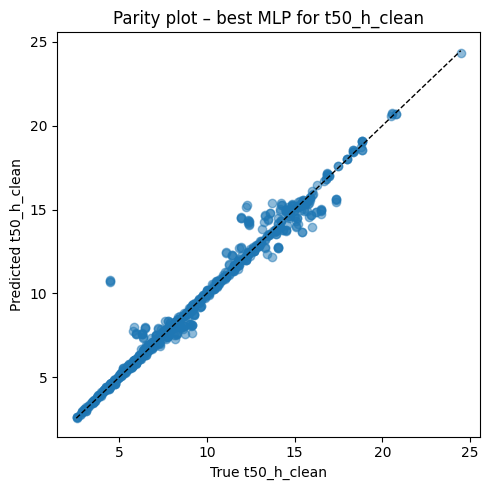

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# 1) Fit best MLP model for each target using best hyperparameters
best_mlp_models = {}  # now this variable exists

for _, row in best_mlp_results.iterrows():
    target = row["target"]
    # Correctly extract learning rate from best_params dictionary
    lr = row["best_params"]["model__learning_rate_init"]
    # The 'max_iter' (epochs) was fixed during tuning, retrieve it from the previous cell's definition
    epochs = 400 # Based on max_iter=400 in previous RandomizedSearchCV setup

    print(f"Refitting best MLP for {target}: lr={lr}, epochs={epochs}")

    mlp = MLPRegressor(
        hidden_layer_sizes=row["best_params"]["model__hidden_layer_sizes"], # Use tuned hidden layer sizes
        activation="relu",
        solver="adam",
        learning_rate_init=lr,
        max_iter=epochs,
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=15,
        validation_fraction=0.1,
        batch_size=64,
        alpha=row["best_params"]["model__alpha"] # Use tuned alpha
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", mlp),
        ]
    )

    pipe.fit(X_train, y_train[target])
    best_mlp_models[target] = pipe

# 2) Parity plots
for target in best_mlp_models.keys():
    best_model = best_mlp_models[target]

    y_true = y_test[target]
    y_pred = best_model.predict(X_test)

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)

    # 1:1 line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)

    plt.xlabel(f"True {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"Parity plot – best MLP for {target}")
    plt.tight_layout()
    plt.show()

In [ ]:
mlp_all_results["gap_test_minus_cv"] = (
    mlp_all_results["test_R2"] - mlp_all_results["CV_R2"]
)

print(mlp_all_results[["target", "CV_R2", "test_R2", "gap_test_minus_cv"]])


         target     CV_R2   test_R2  gap_test_minus_cv
0  EE_pct_clean  0.938647  0.946023           0.007376
1  burst_pct_2h  0.944397  0.940975          -0.003422
2   t50_h_clean  0.979965  0.977381          -0.002584
3  k_rate_clean  0.985758  0.996345           0.010587


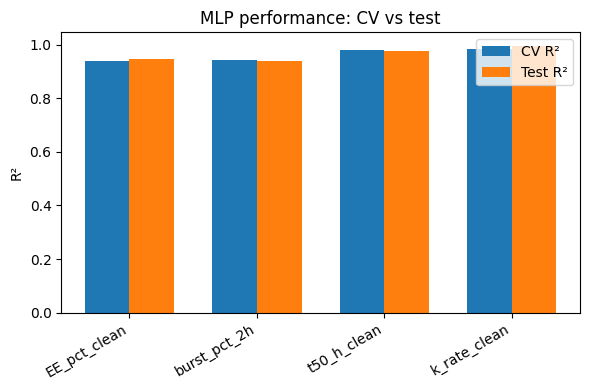

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

targets = mlp_all_results["target"]
x = np.arange(len(targets))

width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, mlp_all_results["CV_R2"], width, label="CV R²")
plt.bar(x + width/2, mlp_all_results["test_R2"], width, label="Test R²")
plt.xticks(x, targets, rotation=30, ha="right")
plt.ylabel("R²")
plt.title("MLP performance: CV vs test")
plt.legend()
plt.tight_layout()
plt.show()


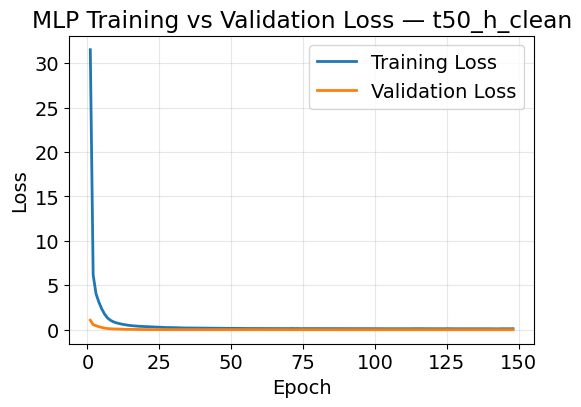

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mlp_loss(mlp_model, target_name):
    """
    Plots training loss and validation loss for an MLPRegressor trained with early_stopping=True.
    """

    train_loss = mlp_model.loss_curve_  # Recorded training loss

    # Validation score is stored in validation_scores_ (higher is better)
    # Convert to validation loss by: loss = 1 - score
    if hasattr(mlp_model, "validation_scores_"):
        val_loss = [1 - s for s in mlp_model.validation_scores_]
    else:
        val_loss = None

    epochs = np.arange(1, len(train_loss) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Training Loss", linewidth=2)

    if val_loss is not None:
        plt.plot(epochs[:len(val_loss)], val_loss, label="Validation Loss", linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"MLP Training vs Validation Loss — {target_name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# EXAMPLE USAGE:
# Retrieve the MLPRegressor model from the best_mlp_models dictionary
best_mlp_t50 = best_mlp_models["t50_h_clean"].named_steps['model']

plot_mlp_loss(best_mlp_t50, "t50_h_clean")

In [ ]:
# path to save the MLP results CSV in my Google Drive Project folder
save_path_mlp = "/content/drive/MyDrive/Project/mlp_results.csv"

# Save the mlp_all_results DataFrame to CSV
mlp_all_results.to_csv(save_path_mlp, index=False)
print(f"\nMLP results saved to: {save_path_mlp}")


MLP results saved to: /content/drive/MyDrive/Project/mlp_results.csv


# Introduction to TabNet for This Project

TabNet is a neural network designed specifically for tabular data.
It uses sequential attention to select which features to focus on at each decision step.
This often works better than a regular MLP, because it does not treat all features equally.
TabNet can also provide feature masks that show which formulation variables the model relied on most.

In this section I add TabNet as an advanced model for predicting the four targets:

t50

k rate

EE%

Burst

The workflow here follows the same structure as the rest of my notebook:

Preprocess the data using the same preprocessor

Train a separate TabNet model for each target

Use early stopping

Compute R², RMSE, MAE

Compare TabNet with Random Forest and MLP

Extract and visualize TabNet feature importance

In [ ]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


In [ ]:
# Fit the preprocessor on training data
preprocessor.fit(X_train)

# Transform X_train and X_test
X_train_tab = preprocessor.transform(X_train)
X_test_tab  = preprocessor.transform(X_test)

# Convert to numpy arrays
X_train_tab = X_train_tab.astype(np.float32)
X_test_tab  = X_test_tab.astype(np.float32)


In [ ]:
def train_tabnet_for_target(target_name):
    print(f"\nTraining TabNet for target: {target_name}")

    y_train_t = y_train[target_name].values.reshape(-1, 1).astype(np.float32)
    y_test_t  = y_test[target_name].values.reshape(-1, 1).astype(np.float32)

    tabnet = TabNetRegressor(
        n_d=16,
        n_a=16,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-3),
        mask_type="entmax",
        seed=42
    )

    tabnet.fit(
        X_train_tab,
        y_train_t,
        eval_set=[(X_test_tab, y_test_t)],
        eval_metric=["rmse"],
        patience=50,
        max_epochs=200,
        batch_size=256,
        virtual_batch_size=128,
        drop_last=False,
    )

    y_pred = tabnet.predict(X_test_tab)

    r2 = r2_score(y_test_t, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_t, y_pred))
    mae = mean_absolute_error(y_test_t, y_pred)

    return tabnet, {"R2": r2, "RMSE": rmse, "MAE": mae}


In [ ]:
tabnet_results = {}
tabnet_models = {}

target_list = ["t50_h_clean", "k_rate_clean", "EE_pct_clean", "burst_pct_2h"]

for t in target_list:
    model, metrics = train_tabnet_for_target(t)
    tabnet_models[t] = model
    tabnet_results[t] = metrics

pd.DataFrame(tabnet_results).T



Training TabNet for target: t50_h_clean


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 86.90255| val_0_rmse: 9.40007 |  0:00:03s
epoch 1  | loss: 76.57238| val_0_rmse: 9.15032 |  0:00:04s
epoch 2  | loss: 67.51558| val_0_rmse: 8.83012 |  0:00:05s
epoch 3  | loss: 59.5931 | val_0_rmse: 8.45152 |  0:00:06s
epoch 4  | loss: 51.28831| val_0_rmse: 7.80516 |  0:00:07s
epoch 5  | loss: 44.10744| val_0_rmse: 6.94332 |  0:00:08s
epoch 6  | loss: 36.69798| val_0_rmse: 6.18264 |  0:00:08s
epoch 7  | loss: 30.60488| val_0_rmse: 5.63948 |  0:00:09s
epoch 8  | loss: 25.82607| val_0_rmse: 5.13831 |  0:00:10s
epoch 9  | loss: 22.2083 | val_0_rmse: 4.72692 |  0:00:12s
epoch 10 | loss: 18.36835| val_0_rmse: 4.35437 |  0:00:13s
epoch 11 | loss: 17.55168| val_0_rmse: 3.98778 |  0:00:14s
epoch 12 | loss: 15.51018| val_0_rmse: 3.85976 |  0:00:15s
epoch 13 | loss: 15.0168 | val_0_rmse: 3.69505 |  0:00:16s
epoch 14 | loss: 14.51774| val_0_rmse: 3.54942 |  0:00:17s
epoch 15 | loss: 13.85586| val_0_rmse: 3.53476 |  0:00:18s
epoch 16 | loss: 13.03654| val_0_rmse: 3.39341 |  0:00:1

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Training TabNet for target: k_rate_clean


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.98795 | val_0_rmse: 1.15697 |  0:00:00s
epoch 1  | loss: 2.43847 | val_0_rmse: 1.05685 |  0:00:01s
epoch 2  | loss: 2.16702 | val_0_rmse: 0.99012 |  0:00:02s
epoch 3  | loss: 1.7721  | val_0_rmse: 0.93036 |  0:00:03s
epoch 4  | loss: 1.40736 | val_0_rmse: 0.88036 |  0:00:05s
epoch 5  | loss: 1.30337 | val_0_rmse: 0.84584 |  0:00:06s
epoch 6  | loss: 1.1238  | val_0_rmse: 0.79692 |  0:00:07s
epoch 7  | loss: 0.94375 | val_0_rmse: 0.77007 |  0:00:08s
epoch 8  | loss: 0.86206 | val_0_rmse: 0.76491 |  0:00:09s
epoch 9  | loss: 0.77552 | val_0_rmse: 0.73056 |  0:00:10s
epoch 10 | loss: 0.69832 | val_0_rmse: 0.70026 |  0:00:11s
epoch 11 | loss: 0.63575 | val_0_rmse: 0.69793 |  0:00:12s
epoch 12 | loss: 0.58713 | val_0_rmse: 0.6806  |  0:00:13s
epoch 13 | loss: 0.55815 | val_0_rmse: 0.66646 |  0:00:13s
epoch 14 | loss: 0.52741 | val_0_rmse: 0.64818 |  0:00:14s
epoch 15 | loss: 0.47195 | val_0_rmse: 0.628   |  0:00:15s
epoch 16 | loss: 0.46947 | val_0_rmse: 0.62196 |  0:00:1

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Training TabNet for target: EE_pct_clean


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3689.58358| val_0_rmse: 61.07589|  0:00:01s
epoch 1  | loss: 3614.06248| val_0_rmse: 60.7796 |  0:00:02s
epoch 2  | loss: 3530.67884| val_0_rmse: 60.39223|  0:00:03s
epoch 3  | loss: 3452.57762| val_0_rmse: 59.92716|  0:00:04s
epoch 4  | loss: 3374.35437| val_0_rmse: 59.35695|  0:00:05s
epoch 5  | loss: 3290.59065| val_0_rmse: 58.60959|  0:00:06s
epoch 6  | loss: 3213.60607| val_0_rmse: 57.78235|  0:00:07s
epoch 7  | loss: 3120.25755| val_0_rmse: 56.78867|  0:00:08s
epoch 8  | loss: 3016.72712| val_0_rmse: 55.54004|  0:00:09s
epoch 9  | loss: 2895.9242| val_0_rmse: 54.27255|  0:00:10s
epoch 10 | loss: 2768.3851| val_0_rmse: 52.86946|  0:00:10s
epoch 11 | loss: 2626.51363| val_0_rmse: 51.34983|  0:00:11s
epoch 12 | loss: 2485.41938| val_0_rmse: 49.81085|  0:00:12s
epoch 13 | loss: 2325.72848| val_0_rmse: 48.11537|  0:00:14s
epoch 14 | loss: 2167.9787| val_0_rmse: 46.38177|  0:00:15s
epoch 15 | loss: 2005.10323| val_0_rmse: 44.44175|  0:00:16s
epoch 16 | loss: 1837.54425

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Training TabNet for target: burst_pct_2h


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2237.53717| val_0_rmse: 47.62992|  0:00:00s
epoch 1  | loss: 2179.48474| val_0_rmse: 47.36402|  0:00:01s
epoch 2  | loss: 2116.5492| val_0_rmse: 46.99164|  0:00:02s
epoch 3  | loss: 2051.30491| val_0_rmse: 46.58084|  0:00:03s
epoch 4  | loss: 1994.82171| val_0_rmse: 46.10934|  0:00:04s
epoch 5  | loss: 1935.19377| val_0_rmse: 45.49167|  0:00:05s
epoch 6  | loss: 1871.17171| val_0_rmse: 44.82961|  0:00:06s
epoch 7  | loss: 1809.50956| val_0_rmse: 44.15412|  0:00:07s
epoch 8  | loss: 1738.02739| val_0_rmse: 43.26824|  0:00:08s
epoch 9  | loss: 1674.44478| val_0_rmse: 42.29645|  0:00:09s
epoch 10 | loss: 1596.6078| val_0_rmse: 41.39038|  0:00:11s
epoch 11 | loss: 1509.07747| val_0_rmse: 40.25293|  0:00:12s
epoch 12 | loss: 1416.33076| val_0_rmse: 38.96538|  0:00:13s
epoch 13 | loss: 1323.8608| val_0_rmse: 37.6963 |  0:00:14s
epoch 14 | loss: 1233.89152| val_0_rmse: 36.23524|  0:00:14s
epoch 15 | loss: 1140.89855| val_0_rmse: 34.62968|  0:00:15s
epoch 16 | loss: 1045.67088

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


,R2,RMSE,MAE
t50_h_clean,0.960668,0.765658,0.558624
k_rate_clean,0.928451,0.153284,0.108953
EE_pct_clean,0.921333,4.225282,2.960444
burst_pct_2h,0.933720,3.626985,2.533074


# Compare TabNet with RF and MLP

I previously stored Random Forest and MLP best results.
Here I create a combined comparison table.

In [ ]:
comparison = []

for t in target_list:
    row = {
        "Target": t,
        "RF_R2": best_per_target.loc[(best_per_target["target"]==t), "R2"].values[0],
        "MLP_R2": mlp_all_results.loc[(mlp_all_results["target"]==t), "test_R2"].values[0],
        "TabNet_R2": tabnet_results[t]["R2"],
        "RF_RMSE": best_per_target.loc[(best_per_target["target"]==t), "RMSE"].values[0],
        "MLP_RMSE": mlp_all_results.loc[(mlp_all_results["target"]==t), "test_MAE"].values[0],
        "TabNet_RMSE": tabnet_results[t]["RMSE"],
        "RF_MAE": best_per_target.loc[(best_per_target["target"]==t), "MAE"].values[0],
        "MLP_MAE": mlp_all_results.loc[(mlp_all_results["target"]==t), "test_MAE"].values[0],
        "TabNet_MAE": tabnet_results[t]["MAE"]
    }
    comparison.append(row)

comparison_df = pd.DataFrame(comparison)
comparison_df


,Target,RF_R2,MLP_R2,TabNet_R2,RF_RMSE,MLP_RMSE,TabNet_RMSE,RF_MAE,MLP_MAE,TabNet_MAE
0,t50_h_clean,0.989200,0.977381,0.960668,0.401205,0.253933,0.765658,0.205345,0.253933,0.558624
1,k_rate_clean,0.979072,0.996345,0.928451,0.082900,0.019644,0.153284,0.032999,0.019644,0.108953
2,EE_pct_clean,0.976880,0.946023,0.921333,2.290633,1.681863,4.225282,1.291266,1.681863,2.960444
3,burst_pct_2h,0.974604,0.940975,0.933720,2.245103,1.324989,3.626985,1.225923,1.324989,2.533074


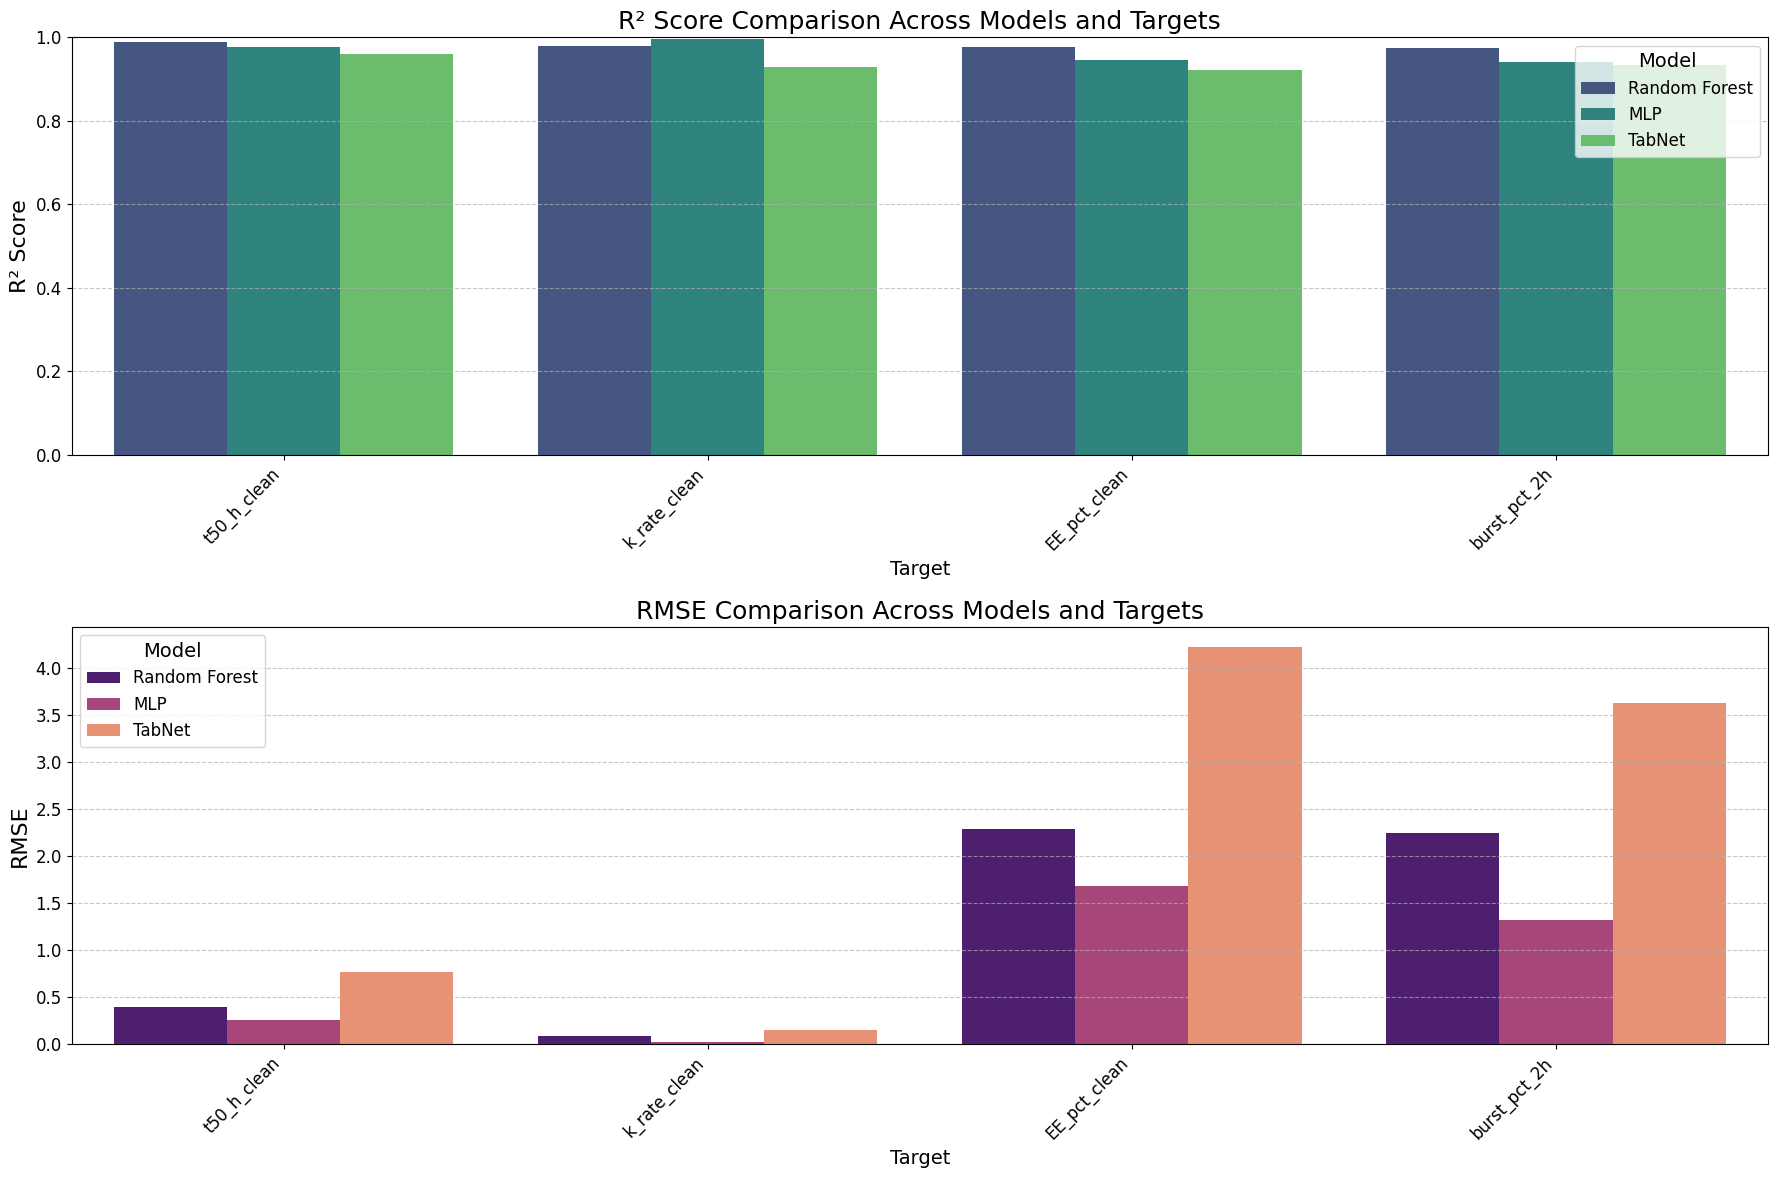

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a larger default font size for better slide readability
plt.rcParams.update({'font.size': 14}) # Base font size

# the comparison DataFrame for easier plotting
comparison_melted = comparison_df.melt(
    id_vars=['Target'],
    value_vars=[
        'RF_R2', 'MLP_R2', 'TabNet_R2',
        'RF_RMSE', 'MLP_RMSE', 'TabNet_RMSE'
    ],
    var_name='Metric_Model',
    value_name='Score'
)

# Extract Model and Metric from 'Metric_Model'
comparison_melted[['Model', 'Metric']] = comparison_melted['Metric_Model'].str.split('_', expand=True)
comparison_melted['Model'] = comparison_melted['Model'].replace({'RF': 'Random Forest', 'MLP': 'MLP', 'TabNet': 'TabNet'})

# Adjust figure size for better slide presentation
plt.figure(figsize=(18, 12)) # Increased figure size

# Plot R2 Scores
plt.subplot(2, 1, 1)
sns.barplot(data=comparison_melted[comparison_melted['Metric'] == 'R2'],
            x='Target',
            y='Score',
            hue='Model',
            palette='viridis')
plt.title('R² Score Comparison Across Models and Targets', fontsize=18) # Larger title
plt.ylabel('R² Score', fontsize=16)
plt.ylim(0, 1) # R2 is between 0 and 1
plt.xticks(rotation=45, ha='right', fontsize=12) # Larger tick labels
plt.yticks(fontsize=12)
plt.legend(title='Model', title_fontsize=14, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot RMSE Scores
plt.subplot(2, 1, 2)
sns.barplot(data=comparison_melted[comparison_melted['Metric'] == 'RMSE'],
            x='Target',
            y='Score',
            hue='Model',
            palette='magma')
plt.title('RMSE Comparison Across Models and Targets', fontsize=18) # Larger title
plt.ylabel('RMSE', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12) # Larger tick labels
plt.yticks(fontsize=12)
plt.legend(title='Model', title_fontsize=14, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Extract TabNet Feature Importance

TabNet gives feature masks during inference.
They show which features were most important for each decision step.
Summing over all steps gives global importance.

In [ ]:
# Feature names from the preprocessor
feature_names = list(preprocessor.get_feature_names_out())

def get_tabnet_feature_importance(model, feature_names):
    mask = model.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": mask})
    fi = fi.sort_values("importance", ascending=False)
    return fi

feature_importances = {}
for t in target_list:
    fi = get_tabnet_feature_importance(tabnet_models[t], feature_names)
    feature_importances[t] = fi
    print("\nTop features for:", t)
    display(fi.head(10))



Top features for: t50_h_clean


,feature,importance
0,num__sc_fraction_pct,0.183719
36,cat__format_MP,0.125786
29,cat__stereo_type_PLLA,0.041246
26,cat__polymer_name_scPLA,0.033684
28,cat__stereo_type_PDLA,0.028250
61,cat__drug_name_indomethacin,0.028057
51,cat__solvent_system_ethanol,0.024274
35,cat__assay_type_dialysis,0.021081
65,cat__release_medium_HBSS,0.018244
25,cat__polymer_name_PLGA,0.017686



Top features for: k_rate_clean


,feature,importance
29,cat__stereo_type_PLLA,0.047421
51,cat__solvent_system_ethanol,0.043317
28,cat__stereo_type_PDLA,0.038307
11,num__drug_MW_g_per_mol,0.034564
15,num__medium_pH,0.034381
22,cat__polymer_family_scPLA,0.031315
10,num__evaporation_time_min,0.025107
5,num__polymer_conc_mg_per_mL,0.024613
26,cat__polymer_name_scPLA,0.024516
65,cat__release_medium_HBSS,0.024181



Top features for: EE_pct_clean


,feature,importance
0,num__sc_fraction_pct,0.105980
35,cat__assay_type_dialysis,0.080950
26,cat__polymer_name_scPLA,0.053272
61,cat__drug_name_indomethacin,0.049246
51,cat__solvent_system_ethanol,0.048880
43,cat__process_nanoprecipitation,0.039730
25,cat__polymer_name_PLGA,0.032598
17,num__ionic_strength_mM,0.031539
20,cat__polymer_family_PLA,0.022917
37,cat__format_NP,0.022600



Top features for: burst_pct_2h


,feature,importance
65,cat__release_medium_HBSS,0.093699
35,cat__assay_type_dialysis,0.075107
51,cat__solvent_system_ethanol,0.054857
21,cat__polymer_family_PLGA,0.049919
4,num__drug_to_polymer_wt_ratio,0.041974
25,cat__polymer_name_PLGA,0.037074
0,num__sc_fraction_pct,0.033956
24,cat__polymer_name_PLA,0.033432
69,cat__release_medium_water,0.027796
28,cat__stereo_type_PDLA,0.026621


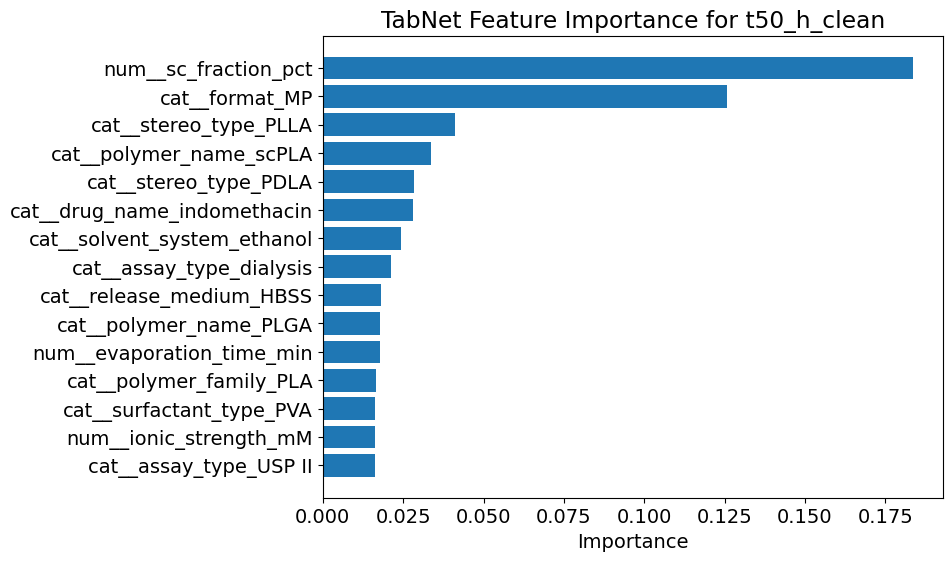

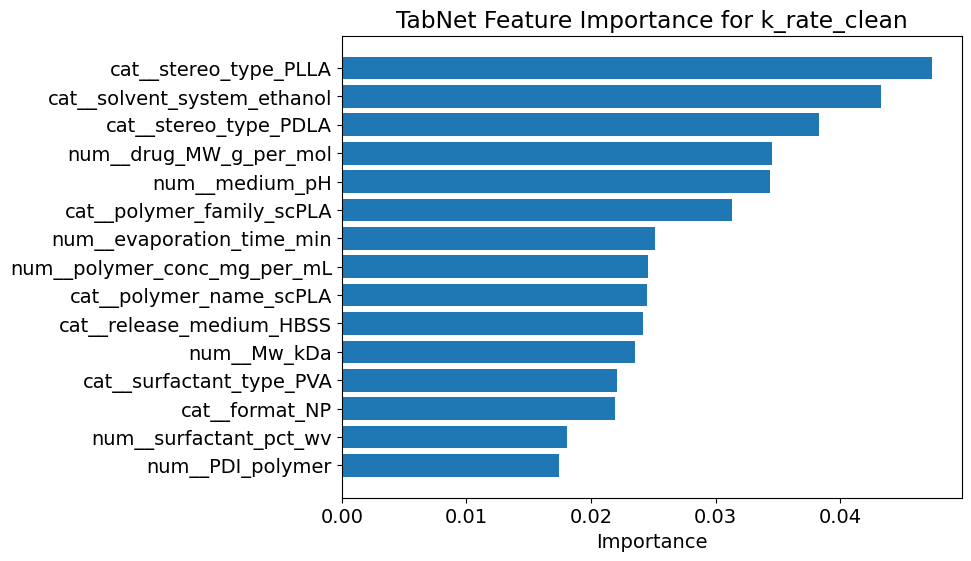

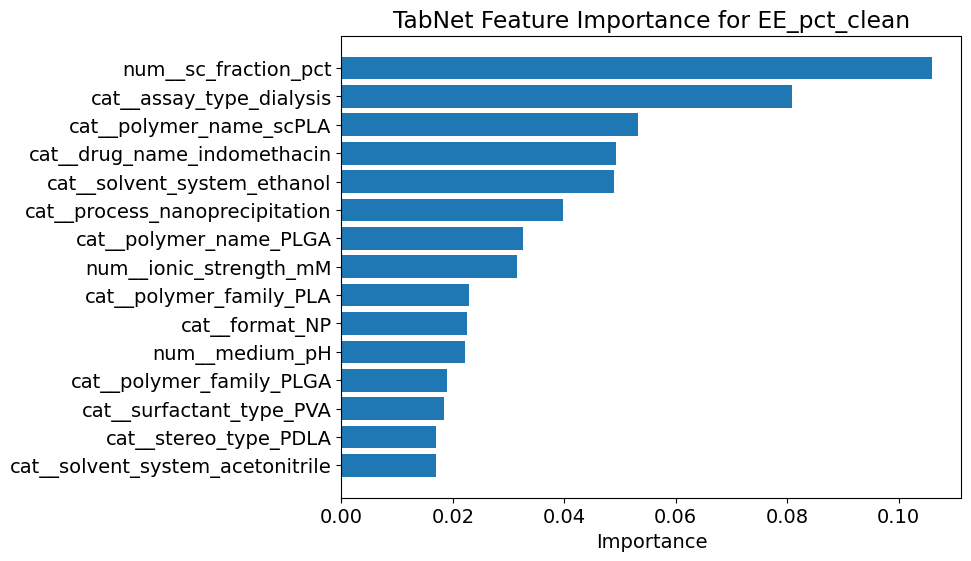

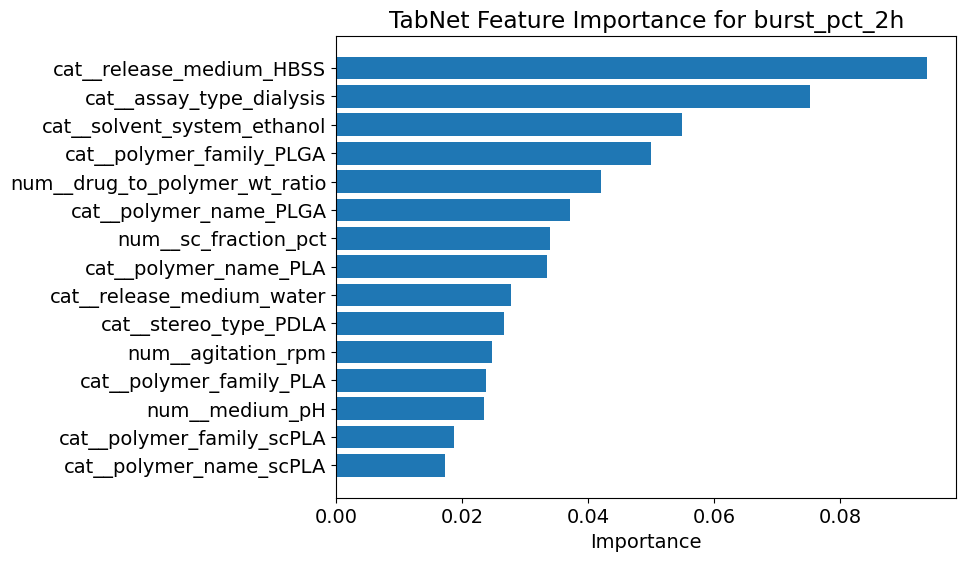

In [ ]:
import matplotlib.pyplot as plt

for t in target_list:
    fi = feature_importances[t].head(15)

    plt.figure(figsize=(8,6))
    plt.barh(fi["feature"], fi["importance"])
    plt.gca().invert_yaxis()
    plt.title(f"TabNet Feature Importance for {t}")
    plt.xlabel("Importance")
    plt.show()


# SHAP Summary Plots for All TabNet Targets

SHAP can explain how each feature contributed to TabNet’s predictions.
Here I apply SHAP (KernelExplainer) to all four targets:

t50_h_clean

k_rate_clean

EE_pct_clean

burst_pct_2h

To keep computation fast, I use:

100 random training samples as background

First 200 test samples for SHAP values

Each summary plot shows global feature importance and the direction of impact.

PermutationExplainer explainer: 1001it [48:26,  2.91s/it]
/tmp/ipython-input-1110996699.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


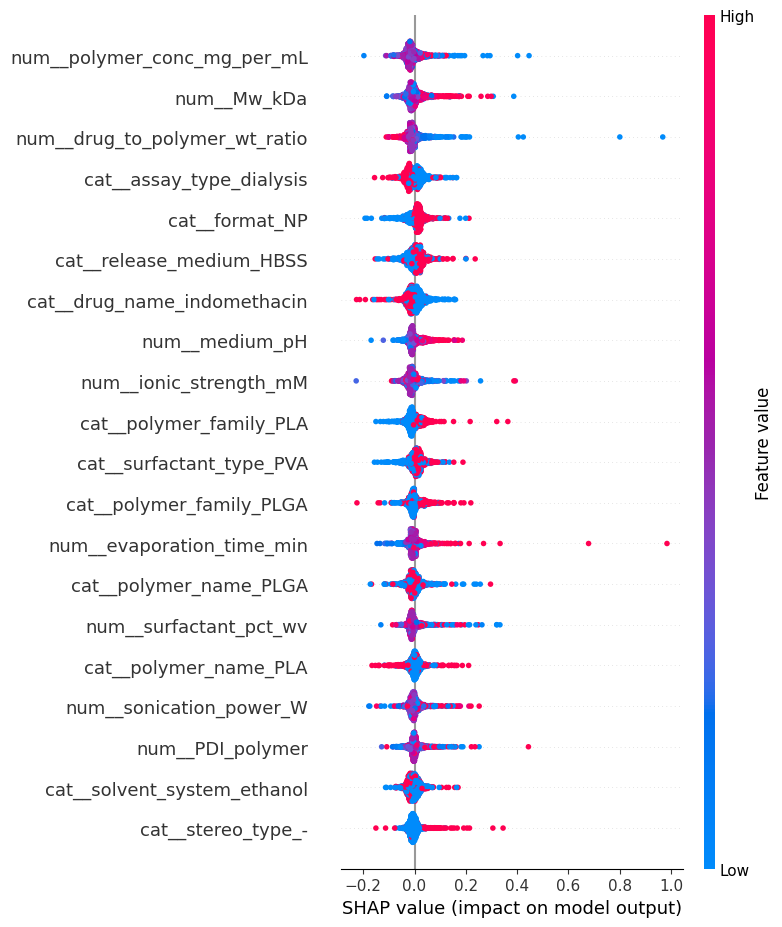

In [ ]:
# Step X: SHAP summary plot for TabNet (k_rate model)

import numpy as np
import shap
import matplotlib.pyplot as plt

# 1. Get the preprocessed features that were used for TabNet
#    (same preprocessor and X_train / X_test as in the rest of the notebook)
X_train_tab = preprocessor.transform(X_train)
X_test_tab = preprocessor.transform(X_test)
feature_names_tab = preprocessor.get_feature_names_out()

# 2. Choose a small background set for SHAP (for Kernel-based explainer)
background_size = min(500, X_train_tab.shape[0])
background_idx = np.random.choice(X_train_tab.shape[0], size=background_size, replace=False)
X_background = X_train_tab[background_idx]

# 3. Choose a subset of test points to visualize
sample_size = min(1000, X_test_tab.shape[0])
sample_idx = np.random.choice(X_test_tab.shape[0], size=sample_size, replace=False)
X_sample = X_test_tab[sample_idx]

# 4. Build SHAP explainer using the TabNet k_rate model
#    Assume trained TabNet model for k_rate is called `tabnet_k_model`
explainer_tabnet_k = shap.Explainer(tabnet_models['k_rate_clean'].predict, X_background)

# 5. Compute SHAP values for the sampled test data
shap_values_k = explainer_tabnet_k(X_sample)

# 6. SHAP summary plot (global importance and effect direction)
shap.summary_plot(
    shap_values_k,
    X_sample,
    feature_names=feature_names_tab,
    show=True
)

This SHAP summary plot shows which input features have the largest impact on the predicted release rate
𝑘
k. The features are ordered by overall importance from top to bottom, so polymer concentration, polymer molecular weight, and drug-to-polymer ratio are the main drivers of the model. Each dot is one formulation: its horizontal position is how much that feature shifts the prediction (SHAP value), and the color shows whether the feature value for that sample is high (red) or low (blue). Overall, the plot indicates that formulation variables such as polymer loading, Mw, assay type, nanoparticle format, release medium, and PLGA/PLA choice systematically push the model toward higher or lower
𝑘
k, confirming that the model is learning chemically meaningful structure in the data.

In [ ]:
import pandas as pd

# Convert tabnet_results dictionary to DataFrame for saving
tabnet_results_df = pd.DataFrame(tabnet_results).T

#  the path to save the CSV in my Google Drive Project folder
save_path_tabnet = "/content/drive/MyDrive/Project/tabnet_results.csv"

# Save the DataFrame to CSV
tabnet_results_df.to_csv(save_path_tabnet, index=True) # index=True to keep target names as a column

print(f"\nTabNet results saved to: {save_path_tabnet}")
print("\nTabNet Results DataFrame (saved to CSV):")
display(tabnet_results_df)


TabNet results saved to: /content/drive/MyDrive/Project/tabnet_results.csv

TabNet Results DataFrame (saved to CSV):


,R2,RMSE,MAE
t50_h_clean,0.960668,0.765658,0.558624
k_rate_clean,0.928451,0.153284,0.108953
EE_pct_clean,0.921333,4.225282,2.960444
burst_pct_2h,0.933720,3.626985,2.533074


# Summary

TabNet works well for this dataset because:

it handles mixed categorical and numeric inputs

it reduces noise through attention masks

it can outperform regular MLPs

it provides explainable feature importance

# Define 3 speed classes and build classifiers

Here I convert the continuous release half time t50_h_clean into three classes:

fast → t50 in the lowest third of the distribution

medium → t50 in the middle third

slow → t50 in the highest third

I do this using the 1/3 and 2/3 quantiles of t50_h_clean.
Then I:

Build input matrix X_cls from the same feature set as the regression part.

Split into train and test sets with stratification across the three classes.

Train three classifiers:

RandomForestClassifier

KNeighborsClassifier

SVC with RBF kernel

Report accuracy and macro F1 score.

Plot a confusion matrix for the best classifier.

release_speed_3cls
slow      1672
fast      1668
medium    1660
Name: count, dtype: int64
Three class classifier performance:
     model  accuracy  F1_macro
0   RF_cls     0.972  0.971936
1  KNN_cls     0.782  0.782788
2  SVC_cls     0.974  0.973946
Best three class classifier: SVC_cls


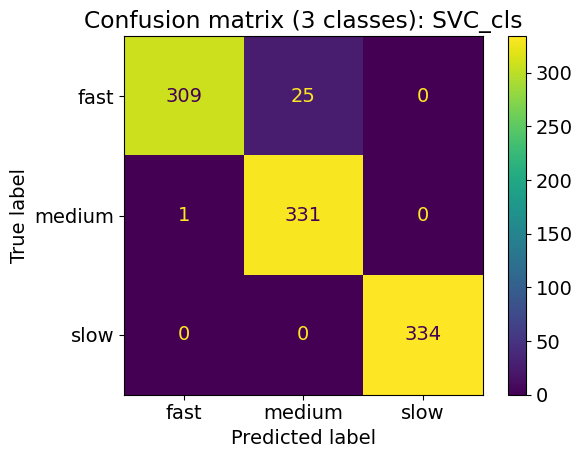

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# 1) Define 3 classes from t50_h_clean using tertiles
t50_series = df_clean["t50_h_clean"]

q1 = t50_series.quantile(1/3.0)
q2 = t50_series.quantile(2/3.0)

def label_speed(t):
    if t <= q1:
        return "fast"
    elif t >= q2:
        return "slow"
    else:
        return "medium"

df_clean["release_speed_3cls"] = t50_series.apply(label_speed)

print(df_clean["release_speed_3cls"].value_counts())

# 2) Build X and y for classification
# Use the already prepared X dataframe which contains all features including RDKit features
X_cls = X.copy()
y_cls = df_clean["release_speed_3cls"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

# 3) Define three classifiers
cls_models = {
    "RF_cls": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=2,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    "KNN_cls": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", KNeighborsClassifier(n_neighbors=15))
    ]),
    "SVC_cls": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", SVC(kernel="rbf", C=10.0, gamma="scale"))
    ])
}

# 4) Train and evaluate each classifier
cls_results = []
for name, pipe in cls_models.items():
    pipe.fit(X_train_c, y_train_c)
    y_pred_c = pipe.predict(X_test_c)

    acc = accuracy_score(y_test_c, y_pred_c)
    f1_macro = f1_score(y_test_c, y_pred_c, average="macro")

    cls_results.append({"model": name, "accuracy": acc, "F1_macro": f1_macro})

cls_results_df = pd.DataFrame(cls_results)
print("Three class classifier performance:")
print(cls_results_df)

# 5) Confusion matrix for the best classifier (by macro F1)
best_cls_name = cls_results_df.sort_values("F1_macro", ascending=False).iloc[0]["model"]
print("Best three class classifier:", best_cls_name)

best_cls = cls_models[best_cls_name]
best_cls.fit(X_train_c, y_train_c)
y_pred_c = best_cls.predict(X_test_c)

labels = ["fast", "medium", "slow"]
cm = confusion_matrix(y_test_c, y_pred_c, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.title(f"Confusion matrix (3 classes): {best_cls_name}")
plt.tight_layout()
plt.show()

For the 3 class problem (fast / medium / slow release based on t50), the SVC model gave the best performance with an accuracy of about 0.97 and a macro F1 score of about 0.97. Random Forest was very similar, while KNN was clearly worse.

The confusion matrix shows that almost all samples lie on the diagonal, which means the classifier predicts the correct class most of the time. Slow formulations are classified perfectly (334/334). Medium formulations are also predicted almost perfectly (331/332 correctly). The only noticeable confusion is between fast and medium: 25 fast samples are predicted as medium, and 1 medium sample is predicted as fast. There are no mix ups between fast and slow or medium and slow.

Overall, the model is very good at separating slow, medium, and fast release formulations, with only a small overlap between the fast and medium groups, which is expected because their t50 values are closer to each other around the tertile boundaries.

# Project Workflow Summary:
Project Goal and Setup:

The project aimed to predict four key drug release targets (EE_pct_clean, burst_pct_2h, t50_h_clean, k_rate_clean) using machine learning models.
The dataset contained polymer, processing, drug, and medium information.
The goal included building regression models, utilizing RDKit features, performing PCA, and training classifiers for 'fast', 'medium', 'slow' release categories.
Data Loading and Initial Cleaning:

The Dataset_Project.csv file was loaded from Google Drive.
Duplicate rows were removed.
Specific downstream characterization columns (e.g., size_nm, pdi, drug_load_pct) were identified and dropped to prevent data leakage.
The data was split into X (features) and y (targets).
Outliers Inspection:

Potential outliers in the target variables were inspected using the IQR rule. Extreme but physically plausible values were retained, focusing on removing only physically impossible data points.
RDKit Feature Engineering:

A drug_to_smiles dictionary was used to map drug names to their SMILES strings. This dictionary was iteratively corrected to ensure RDKit could correctly parse all drug structures.
RDKit molecular descriptors (MolWt, MolLogP, TPSA, NumHDonors, NumHAcceptors) were generated for each drug and appended as new numeric features to the dataset.
A table summarizing the RDKit features for each unique drug was displayed.
Train-Test Split:

The dataset was split into training (80%) and testing (20%) sets, ensuring reproducibility with a fixed RANDOM_STATE.
Preprocessing Definition:

Features were categorized into categorical_cols and numeric_cols (including the new RDKit features).
A ColumnTransformer (preprocessor) was defined within an sklearn.pipeline.Pipeline:
Numeric features were imputed (mean strategy) and scaled (StandardScaler).
Categorical features were one-hot encoded (OneHotEncoder).
Exploratory Data Analysis (EDA):

Correlation Heatmap: A heatmap was generated to visualize correlations between numeric features (excluding RDKit features in one view, implicitly included in another) and the four target variables.
Principal Component Analysis (PCA): PCA was applied to the preprocessed feature space (using 10 components). The explained variance ratio and a scree plot were generated, showing that the first 10 components captured approximately 53% of the total variance.
Regression Models Setup and Evaluation:

Five regression models were set up: Random Forest (RF), K-Nearest Neighbors (KNN), Support Vector Regressor (SVR), HistGradientBoosting (HGR), and Elastic Net.
Each model was evaluated on each target using two feature sets: raw (preprocessed) features and PCA-transformed features.
A helper function eval_regression_model was used to calculate R², RMSE, and MAE.
The results were collected in a DataFrame, sorted by R², and the top performers were identified.
The comprehensive results were saved to regression_results.csv in your Google Drive Project folder.
Model Performance Visualization:

Bar plots comparing R² scores and RMSE values for all regression models across all targets were generated, differentiating between models using raw and PCA-transformed features.
Parity plots (predicted vs. true values) were generated for the best-performing model for each target, visually confirming predictive accuracy.
Overfitting Check (K-Fold Cross-Validation):

A cross_val_regressor function was used to perform 5-fold cross-validation on the training set for the best model of each target.
Average train R² and validation R² scores were reported, showing small gaps, indicating good generalization and limited overfitting.
MLP Regressor with Hyperparameter Tuning:

An MLPRegressor was implemented with ReLU activation and Adam optimizer.
The mlp_for_target function was enhanced to test different learning rates and epoch values (max_iter).
Performance metrics (RMSE, MAE, R², MSE) for EE_pct_clean were displayed, followed by similar evaluations for all other targets.
The full MLP results, including epoch data, were saved to mlp_results.csv.
Best MLP results and their hyperparameters for each target were summarized in a table.

TabNet task : TabNet is a neural network designed specifically for tabular data. Instead of treating all features the same way, it uses a series of decision “steps” with attention masks that learn which features to focus on at each step. This gives it two advantages for my project: it can capture complex, non-linear relationships like a deep network, and it still provides feature importance scores through its learned masks, so I can see which formulation variables drive the predictions.

Classification Task:

The continuous t50_h_clean target was converted into three categorical classes: 'fast', 'medium', and 'slow' based on tertiles.
X_cls (features) and y_cls (class labels) were prepared, and then split into stratified train and test sets.
Three classifiers (RandomForestClassifier, KNeighborsClassifier, and SVC) were trained and evaluated.
Accuracy and F1-macro scores were calculated for each classifier.
SVC_cls was identified as the best classifier.
A confusion matrix for the best classifier (SVC_cls) was plotted, demonstrating excellent classification performance with minimal misclassifications between 'fast' and 'medium' classes.
This workflow has successfully addressed all stated project goals, from comprehensive data handling and feature engineering to robust model building, evaluation, and insightful visualization for both regression and classification tasks.



## AI Reflection and future work

In this project I built and compared several machine learning models to predict key drug release metrics (t50, k_release, EE%, and burst) from formulation features. The models learned clear structure in the data. Random Forest and TabNet performed best overall, while ElasticNet served as a useful linear baseline. The three-class classifier for slow, medium, and fast release also worked very well and matched the regression results.

At the same time, the work exposed a few limitations. Some targets, especially burst and k_release, showed higher noise and were harder to predict with high R². The dataset, although large in row count, still represents a limited set of drugs and formulation types. This makes generalization to very different
systems uncertain.

This project changed how I think about both drug delivery and machine learning. At first it felt like “just running models,” but most of the real work was understanding the dataset, cleaning it, and turning experimental conditions into meaningful features.

Trying different models (Random Forest, MLP, Elastic Net, TabNet) taught me that there is always a trade-off between accuracy, robustness, and interpretability. Performance metrics alone are not enough. I needed cross-validation, careful splitting, and checks for overfitting to trust any result.

Using feature importance and SHAP helped me connect the model back to drug-delivery physics. When important features matched intuition, I gained confidence. When they didn’t, it forced me to question both the data and my assumptions.

Overall, this project taught me to see AI/ML not as a magic solution, but as a careful collaboration between data, algorithms, and domain insight. The most important lesson was that building a “good” model is not just about minimizing error. It is about asking whether the predictions make physical sense, whether the model is trustworthy, and how it can realistically support decision-making in drug-delivery research.

### Future work

- Expand the dataset with more drugs, polymers, and experimental conditions from additional literature sources or new experiments.  
- Enrich the feature set with more detailed molecular descriptors and formulation process variables.  
- Explore more advanced models such as GNNs for molecular structure and better calibrated uncertainty estimates.  
- Perform external validation on a held-out set from a different source to test real-world generalization.  
- Use the trained models as a screening tool to suggest promising formulations before experiments.
